# Template Pipeline
Normalisation&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
**X -> Gaussian**  
Imputation 1&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
**Median**  
Outlier Detection&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
**Z Score**  
Imputation 2&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
**Median**  
Feature Selection&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
**Implicit to model**  
Model&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
**Lasso Regression**


## Imports

In [ ]:
# General
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ML
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, BayesianRidge
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut

# Custom
import sys,os
sys.path.append('/home/jovyan/work/AML/Task_1/Solution') # I would like a cleaner solution but works for now
import Components.Imputation as Imputation
import Components.Outlier_Detection_1D as Outlier_Detection_1D
import Components.Outlier_Detection_ND as Outlier_Detection_ND
import Components.Feature_Selection as Feature_Selection
import Components.Normalisation as Normalisation
import Components.data_fetching as data_fetching
import Components.data_observations as data_observations

# CAREFUL:
# If you make changes to a custom module, you have to reload it, i.e rerun this cell
import importlib
importlib.reload(Imputation)
importlib.reload(Outlier_Detection_1D)
importlib.reload(Outlier_Detection_ND)
importlib.reload(Feature_Selection)
importlib.reload(Normalisation)
importlib.reload(data_fetching)
importlib.reload(data_observations)

<module 'Components.data_observations' from '/home/jovyan/work/AML/Task_1/Solution/Components/data_observations.py'>

## Data Cleaning

In [ ]:
X, y = data_fetching.get_train_data()
x_test_final = data_fetching.get_test_data()

mv_mask = Imputation.missing_values_mask(X)
X = Imputation.median(X)
X = Normalisation.gaussian(X)
X,y,mv_mask = Outlier_Detection_ND.magic_indices(X,y,n_outliers=50,mask=mv_mask)
X = Outlier_Detection_1D.z_score(X,x_extra=x_test_final)
X = X.mask(mv_mask) # Re-impute the ones we imputed before
X = Imputation.iterative_regression(X)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)

X (1162, 832)
/opt/venv/lib/python3.7/site-packages/sklearn/impute/_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


## Model Training

In [ ]:
lasso = LassoCV(cv=5, random_state=0, max_iter=5000).fit(x_train, y_train)

print('Train Score:')
y_pred_train = lasso.predict(x_train)
train_score = r2_score(y_train, y_pred_train)
print(train_score)

print('Test Score')
y_pred_test = lasso.predict(x_test)
test_score = r2_score(y_test, y_pred_test)
print(test_score)

print('Alphas')
print(lasso.alpha_)
print(lasso_final.alpha_)

/opt/venv/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.23123486847794, tolerance: 7.3005546261089975
  positive)
/opt/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.206855474778195, tolerance: 7.348993544303797
  positive)
/opt/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.58007295090306, tolerance

NameError: name 'lasso_final' is not defined

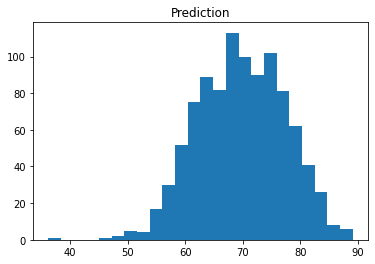

In [ ]:
plt.hist(y_train.iloc[:,0].to_numpy(), bins='auto')
plt.title('Actual')
plt.show()

plt.hist(y_pred_train, bins='auto')
plt.title('Prediction')
plt.show()

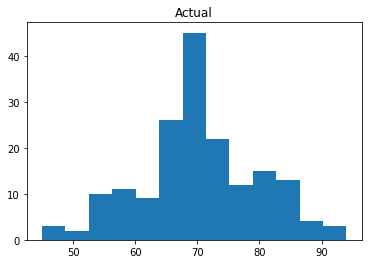

In [ ]:
plt.hist(y_test.iloc[:,0].to_numpy(), bins='auto')
plt.title('Actual')
plt.show()

plt.hist(y_pred_test, bins='auto')
plt.title('Prediction')
plt.show()

## Final Prediction

0.7471499531803909
           y
0  67.174800
1  77.907404
2  64.058608
3  66.886449
4  74.680603


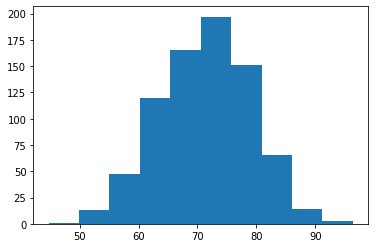

In [ ]:
lasso_final = LassoCV(cv=5, random_state=0).fit(X, y)

print(lasso_final.score(X,y))

x_test_final = data_fetching.get_test_data()

x_test_final = Imputation.mean(x_test_final)
x_test_final = Normalisation.gaussian(x_test_final)

# Note: They said no outliers were introduced in x_test_final so no need to perform outlier detection
y_pred = lasso_final.predict(x_test_final)
plt.hist(y_pred)

y_pred_pd = pd.DataFrame(data=y_pred, columns=["y"])
print(y_pred_pd.head())
y_pred_pd.to_csv('../../Predictions/lasso_brute_regressionimpute.csv', index_label='id')